In [6]:
from utils import *
from scipy.stats import qmc
from scipy.stats import spearmanr
from scipy import optimize
import os
import pandas as pd

In [7]:
def g(ell, gp, mean_ntk, data):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})


    gp.fit(data[0], data[1])
    mean = gp.predict(data[2])
    
    return np.sqrt(np.mean((mean_ntk - mean)**2))

In [58]:
arrsize=30
tmp = np.linspace(1,7, arrsize)
X, Y = np.meshgrid(tmp, tmp)
Z = -20*np.exp(-0.2 * np.sqrt(0.5*(X**2 + Y**2))) - np.exp(0.5 *(np.cos(2*np.pi*X) + np.cos(2*np.pi*Y))) + np.e + 20

# tmp = np.linspace(0,1, arrsize)
# X, Y = np.meshgrid(tmp, tmp)    
# # Franke's function
# Z = (0.75*np.exp(- (9*X - 2)**2/4 - (9*Y - 2)**2/4) + 
#         0.75*np.exp(- (9*X + 1)**2/49 - (9*Y + 1)/10) +
#         0.5*np.exp(- (9*X - 7)**2/4  - (9*Y - 3)**2/4) +
#         0.2*np.exp(- (9*X - 4)**2    - (9*Y - 7)**2))

bigX = np.stack((X,Y), axis=2).reshape(-1,2)
smolY = Z.reshape(-1,1)


datasets = processing(bigX, smolY, noise = 0.15)
X_orig, y = datasets['orig']
X_norm, _ = datasets['norm']
X_train, y_train, y_train_noisy = datasets['orig train']
X_norm_train, _, _ = datasets['norm train']

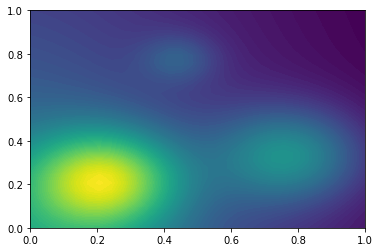

In [59]:
plt.contourf(X,Y,Z, levels=100)

Text(0.02, 0.5, 'Gaus $\\longleftarrow$ LPK $\\longrightarrow$ NTK')

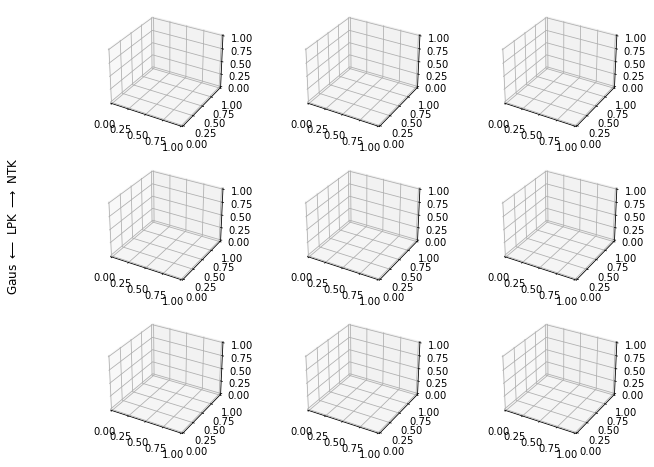

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(10,8))
axes = axes.ravel()
for i in range(0,9):
    axes[i].remove()
    axes[i] = plt.subplot(3,3,i + 1, projection='3d')
    axes[i].patch.set_alpha(0)

fig.supylabel(r'Gaus $\longleftarrow$ LPK $\longrightarrow$ NTK')

In [60]:
%%capture

fig, axes = plt.subplots(3, 3, figsize=(10,8))
axes = axes.ravel()
for i in range(0,9):
    axes[i].remove()
    axes[i] = plt.subplot(3,3,i + 1, projection='3d')
    axes[i].patch.set_alpha(0)

RMSE = []
corr = []

fig1, axes1 = plt.subplots(3,3, figsize=(10,8), sharex=True, sharey=True)
axes1 = axes1.ravel()

fig.supylabel(r'Gaus $\longleftarrow$ LPK $\longrightarrow$ NTK')
fig1.supylabel(r'Gaus $\longleftarrow$ LPK $\longrightarrow$ NTK')

data = (X_norm_train, y_train, X_norm)

for j in range(0,3):
    if j == 0 : depth=3
    if j == 1 : depth=25
    if j == 2 : depth=100

    ntk = (
        ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
        NTK(depth=depth, c=2, bias=0.1, 
            bias_bounds=(1e-9, 1e5)) 
        # +
        # WhiteKernel(
        #     noise_level=0.15**2, 
        #     noise_level_bounds=(1e-4, 0.5))#(0.001, 1))
    )

    gp_ntk = GPR(kernel=ntk, normalize_y=True, alpha=1e-5, n_restarts_optimizer=9, random_state=3480795)
    gp_ntk.fit(data[0], data[1])
    mean_ntk = gp_ntk.predict(data[2])

    print(gp_ntk.kernel_)



    lpk = (
        ConstantKernel(
            constant_value=gp_ntk.kernel_.get_params()['k1__constant_value'],
            constant_value_bounds='fixed'
        ) *
        Matern(
            nu=1/2,
            # anisotropic true -> trying to fit product of laplace kernels with different lengthscales
            length_scale=1,
            length_scale_bounds='fixed'
        ) 
        # + 
        # WhiteKernel(
        #     noise_level=gp_ntk.kernel_.get_params()['k2__noise_level'],
        #     noise_level_bounds='fixed'
        # )
    )

    gp_lpk = GPR(kernel=lpk, alpha=1e-5, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)

    ell_lpk = optimize.minimize_scalar(g, args=(
        gp_lpk, mean_ntk, data), 
        method='bounded', bounds=[0.0001, 10], options={'maxiter': 10000})
    for i in range(-2, 6):
        tmp = optimize.minimize_scalar(g, args=(
            gp_lpk, mean_ntk, data),
            method='bounded', bounds=[0.0001, 10**i], options={'maxiter': 10000})
        if tmp.fun < ell_lpk.fun:
            ell_lpk = tmp

    try:
        gp_lpk.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
    except:
        gp_lpk.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
    gp_lpk.fit(data[0], data[1])
    mean_lpk_opt = gp_lpk.predict(data[2])

    print(gp_lpk.kernel_)
    RMSE.append(ell_lpk.fun)
    corr.append(np.corrcoef((mean_ntk)[:,0], (mean_lpk_opt)[:,0])[0, 1])


    rbf = (
        ConstantKernel(
            constant_value=1,
            constant_value_bounds=(1e-9, 1e5)
        ) *
            Matern(
                nu=np.inf,
                length_scale=1,
                length_scale_bounds='fixed'
            )
        )

    gp_rbf = GPR(kernel=rbf, alpha=1e-5, normalize_y=True, n_restarts_optimizer=0, random_state=3480795)


    ell_rbf = optimize.minimize_scalar(g, args=(
        gp_rbf, mean_ntk, data), 
        method='bounded', bounds=[0.0001, 10], options={'maxiter': 10000})
    for i in range(-2, 6):
        tmp = optimize.minimize_scalar(g, args=(
            gp_rbf, mean_ntk, data),
            method='bounded', bounds=[0.0001, 10**i], options={'maxiter': 10000})
        if tmp.fun < ell_rbf.fun:
            ell_rbf = tmp

    try:
        gp_rbf.set_params(**{'kernel__k2__length_scale': ell_rbf.x})
    except:
        gp_rbf.set_params(**{'kernel__k1__k2__length_scale': ell_rbf.x})
    gp_rbf.fit(data[0], data[1])
    mean_rbf_opt = gp_rbf.predict(data[2])

    print(gp_rbf.kernel_)
    RMSE.append(ell_rbf.fun)
    corr.append(np.corrcoef((mean_ntk)[:,0], (mean_rbf_opt)[:,0])[0, 1])



    axes[j + 0].contourf(
        X_orig[:,0].reshape(-1, arrsize), 
        X_orig[:,1].reshape(-1, arrsize), 
        mean_ntk.reshape(-1, arrsize),
        levels=100)
    beta = gp_ntk.kernel_.get_params()['k2__bias']
    a,b = f'{beta:.3e}'.split('e')
    b = int(b)
    axes[j + 0].set_title(f'Depth = {depth}, ' + rf'$\beta = {a}\cdot 10^{{{b}}}$')

    axes[j + 3].contourf(
        X_orig[:,0].reshape(-1, arrsize), 
        X_orig[:,1].reshape(-1, arrsize), 
        mean_lpk_opt.reshape(-1, arrsize),
        levels=100)
    axes[j + 3].set_title(r'$\ell$ =' + f" {round(gp_lpk.kernel_.get_params()['k2__length_scale'], 4)}")

    axes[j + 6].contourf(
        X_orig[:,0].reshape(-1, arrsize), 
        X_orig[:,1].reshape(-1, arrsize), 
        mean_rbf_opt.reshape(-1, arrsize),
        levels=100)
    axes[j + 6].set_title(r'$\ell$ =' + f" {round(gp_rbf.kernel_.get_params()['k2__length_scale'], 4)}")


    axes1[j + 0].contourf(
        X_orig[:,0].reshape(-1, arrsize), 
        X_orig[:,1].reshape(-1, arrsize), 
        mean_ntk.reshape(-1, arrsize),
        levels=100)
    beta = gp_ntk.kernel_.get_params()['k2__bias']
    a,b = f'{beta:.3e}'.split('e')
    b = int(b)
    axes1[j + 0].set_title(f'Depth = {depth}, ' + rf'$\beta = {a}\cdot 10^{{{b}}}$')

    axes1[j + 3].contourf(
        X_orig[:,0].reshape(-1, arrsize), 
        X_orig[:,1].reshape(-1, arrsize), 
        mean_lpk_opt.reshape(-1, arrsize),
        levels=100)
    axes1[j + 3].set_title(r'$\ell$ =' + f" {round(gp_lpk.kernel_.get_params()['k2__length_scale'], 4)}")

    axes1[j + 6].contourf(
        X_orig[:,0].reshape(-1, arrsize), 
        X_orig[:,1].reshape(-1, arrsize), 
        mean_rbf_opt.reshape(-1, arrsize),
        levels=100)
    axes1[j + 6].set_title(r'$\ell$ =' + f" {round(gp_rbf.kernel_.get_params()['k2__length_scale'], 4)}")

In [61]:
print('RMSE', RMSE)
print('corr', corr)

RMSE [1.524580100741755e-06, 0.05528927336089811, 0.00013442749833328418, 0.055240637902933286, 0.0005866337552547498, 0.05472466713852351]
corr [0.9999999999851485, 0.9651768526731084, 0.9999997966847519, 0.9652382456062292, 0.9999961740611792, 0.9658420731243555]


In [32]:
fig.tight_layout()
fig.savefig('./ackleyNormNoNoise3D.png', dpi=150)
fig.savefig('./ackleyNormNoNoise3D.svg')
fig1.tight_layout()
fig1.savefig('./ackleyNormNoNoise2D.png', dpi=150)
fig1.savefig('./ackleyNormNoNoise2D.svg')

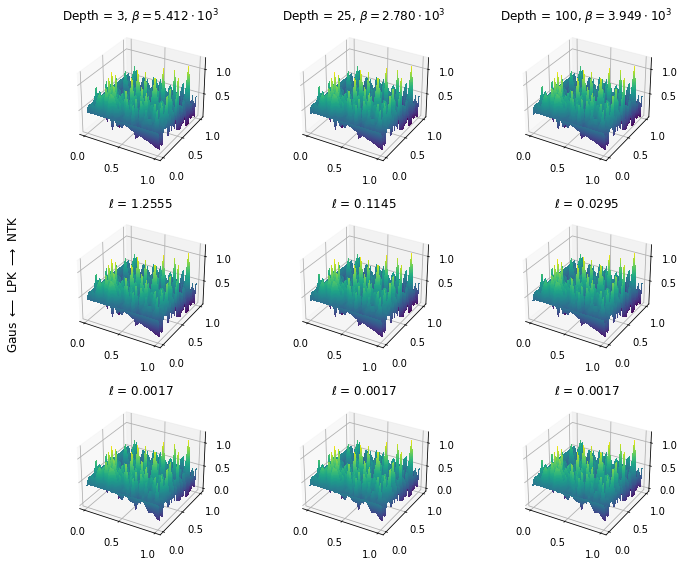

In [62]:
fig.tight_layout()
fig

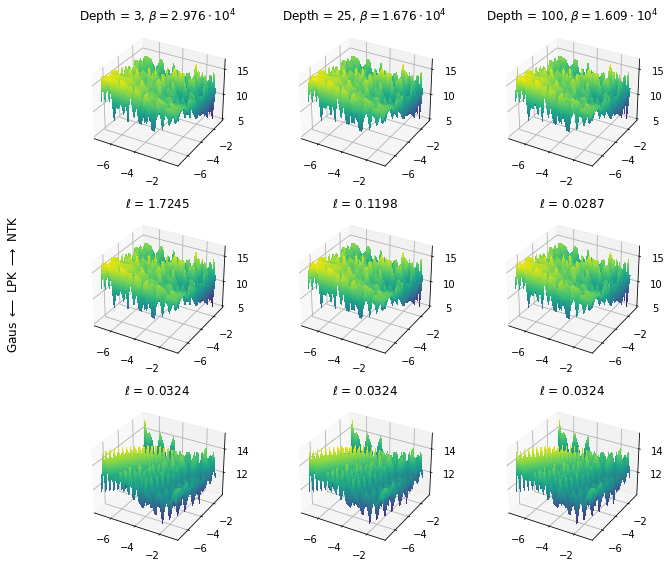

In [47]:
fig.tight_layout()
fig

In [26]:
axes[0 + 0].contourf(
        X_orig[:,0].reshape(-1, 40), 
        X_orig[:,1].reshape(-1, 40), 
        mean_ntk.reshape(-1, 40),
        levels=100, cmap='plasma')
beta = gp_ntk.kernel_.get_params()['k2__bias']
a,b = f'{beta:.3e}'.split('e')
b = int(b)
axes[0 + 0].set_title(f'Depth = {depth}, ' + rf'$\beta = {a}\cdot 10^{{{b}}}$')

axes[0 + 3].contourf(
    X_orig[:,0].reshape(-1, 40), 
    X_orig[:,1].reshape(-1, 40), 
    mean_lpk_opt.reshape(-1, 40),
    levels=100, cmap='viridis')
axes[0 + 3].set_title(r'$\ell$ =' + f" {round(gp_lpk.kernel_.get_params()['k2__length_scale'], 4)}")

Text(0.5, 0.92, '$\\ell$ = 23606797.7501')

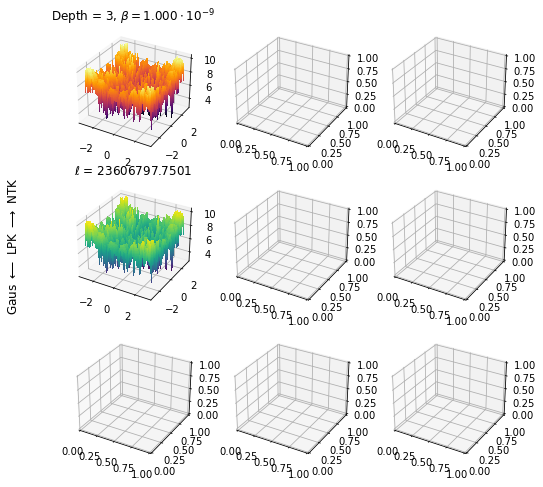

In [27]:
fig